In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [83]:
train_file = "../Data/Train/trains1990s.csv"

# Load the data
df = pd.read_csv(train_file, parse_dates=['observation_date'], date_format="%m/%y"
)
df = df[['observation_date', 'fred_PCEPI', 'fred_AHETPI']] # Use average hourly earnings cause it is not possible to train VAR with only one variable
df.set_index('observation_date', inplace=True)

In [84]:
numVals = df.shape[0]
valRatio = 0.2
splitLoc = int(numVals * (1 - valRatio))

train = df.iloc[:splitLoc]
val = df.iloc[splitLoc:]

In [85]:
# Prepare the VAR model with both variables
model = VAR(train[['fred_PCEPI', 'fred_AHETPI']])
# Let the model select the best lag up to 5.
model_fit = model.fit(maxlags=5, ic='aic')
print(model_fit.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 18, Feb, 2025
Time:                     13:34:13
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -11.3638
Nobs:                     292.000    HQIC:                  -11.5299
Log likelihood:           892.901    FPE:                8.80001e-06
AIC:                     -11.6408    Det(Omega_mle):     8.17266e-06
--------------------------------------------------------------------
Results for equation fred_PCEPI
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.647515         0.250999            2.580           0.010
L1.fred_PCEPI          1.448072         0.059372           24.390           0.000
L1.fred_AHETPI         0.172199         0.419095   

/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Users/natalieleung/miniforge3/envs/nat/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [86]:
lag_order = model_fit.k_ar  # Number of lags used in the model
print(f"Using lag order: {lag_order}")

# Use the last lag_order from the training data to forecast
forecast_input = train[['fred_PCEPI', 'fred_AHETPI']].values[-lag_order:]
forecast_steps = len(val)
forecast = model_fit.forecast(y=forecast_input, steps=forecast_steps)

Using lag order: 5


In [87]:
forecast_df = pd.DataFrame(forecast, index=val.index, columns=['fred_PCEPI', 'fred_AHETPI'])
# Calculate RMSE for fred_PCEPI predictions
rmse = np.sqrt(mean_squared_error(val['fred_PCEPI'].values, forecast_df['fred_PCEPI'].values))
print(f'Validation RMSE for fred_PCEPI: {rmse}')

Validation RMSE for fred_PCEPI: 1.559507679441776


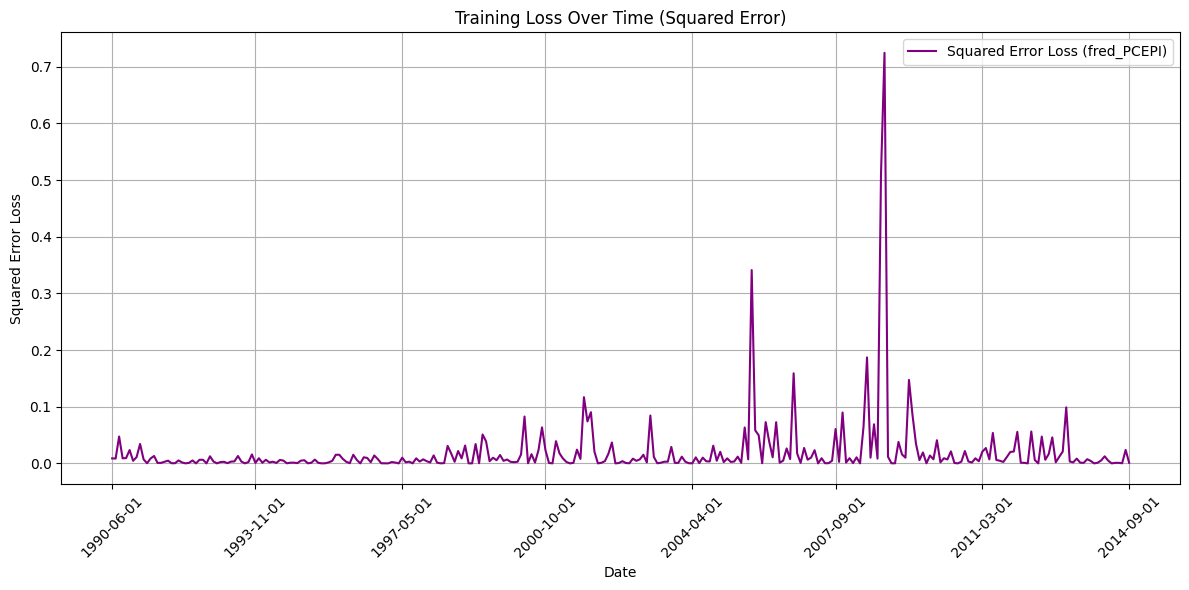

In [88]:
# Extract residuals (errors) for fred_PCEPI from the VAR model fit
residuals = model_fit.resid['fred_PCEPI']

# Compute squared errors (loss) at each time point
squared_errors = residuals ** 2

# Plot the squared error loss over time
plt.figure(figsize=(12, 6))
plt.plot(squared_errors.index, squared_errors, label='Squared Error Loss (fred_PCEPI)', color='purple')
plt.title("Training Loss Over Time (Squared Error)")
plt.xlabel("Date")
plt.ylabel("Squared Error Loss")
plt.legend()
plt.grid(True)

# Choose 8 evenly spaced tick positions along the x-axis
tick_indices = np.linspace(0, len(squared_errors.index) - 1, 8, dtype=int)
tick_dates = [squared_errors.index[i] for i in tick_indices]
# Format the tick labels as strings (e.g., 'YYYY-MM-DD')
tick_labels = [pd.to_datetime(date).strftime('%Y-%m-%d') for date in tick_dates]

plt.xticks(tick_dates, tick_labels, rotation=45)
plt.tight_layout()
plt.show()

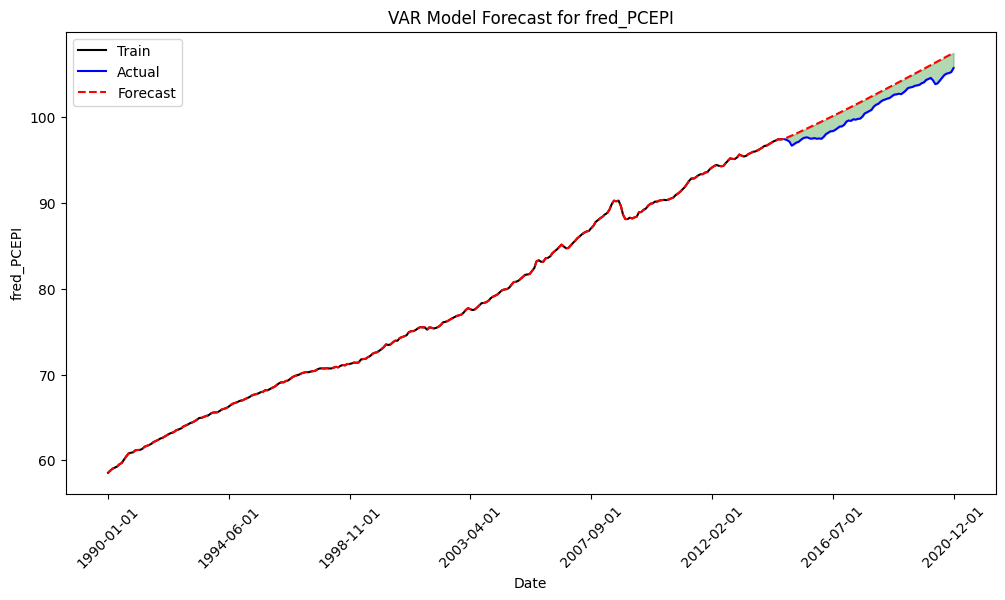

In [89]:
full_forecast = np.concatenate([
    train['fred_PCEPI'].values,
    forecast_df['fred_PCEPI'].values
])

full_index = train.index.append(val.index)

# Plot the training data, actual validation data, and the forecast line
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train['fred_PCEPI'], label='Train', color='black')
ax.plot(val.index, val['fred_PCEPI'], label='Actual', color='blue')
ax.plot(full_index, full_forecast, label='Forecast', linestyle='--', color='red')

# Fill the area between the actual and forecast over the validation period
ax.fill_between(val.index, 
                val['fred_PCEPI'], 
                forecast_df['fred_PCEPI'], 
                color='green', alpha=0.3)

ax.set_title('VAR Model Forecast for fred_PCEPI')
ax.set_xlabel('Date')
ax.set_ylabel('fred_PCEPI')
ax.legend()

# Create 8 evenly spaced ticks based on the full index length.
tick_indices = np.linspace(0, len(full_index) - 1, 8, dtype=int)
tick_dates = [full_index[i] for i in tick_indices]
tick_labels = [pd.to_datetime(date).strftime('%Y-%m-%d') for date in tick_dates]

ax.set_xticks(tick_dates)
ax.set_xticklabels(tick_labels, rotation=45)

plt.show()